# Diamond Price Analysis
---
### Authors:
* Marcin Bereźnicki
* Jakub Burczyk
---
### The problem:
The purpose of the project was to analyze diamond's pricing based on it's weight.

### The goal:
We hope, that after creating sufficient model it will be possible to predict a price for gem given it's mass in carats. 

It may be possible to estimate a price without any trade specific knowledge for example about type of cuts, which could prevent getting ripped off by sellers/buyers.

---

# Table of contents
We highly recommend using provided hyperlinks to sections.

* [Dataset](#dataset)
* [Python modules](#imports)
* [Data Tidying](#data-tidying)
  * [Dropping indexes](#dropping-index)
  * [Mass and price extraction](#mass-and-price-extraction)
  * [Plotting dataset and polynomial fitting](#plotting-dataset-and-polynomial-fitting)
* [Data Analysis](#data-analysis)
  * [Loading dataset](#loading-dataset)
  * [Model 1 - 1st degree polynomial regression](#model-1---linear-regression---1st-degree)
    * [Prior predictive check](#model-1---prior-predictive-check)
    * [Posterior analysis](#model-1---posterior-analysis)
    * [Linear regression](#model-1---stan-linear-regression)
    * [Model parameters](#model-1---model-parameters)
    * [Evaluation](#model-1---evaluation)
      * [Quantiles](#model-1---quantiles)
      * [Predictions and density](#model-1---predictions-and-density-plot)
  * [Model Comparison](#model-comparison)
    * [PSIS-LOO Criterion](#psis-loo-criterion)
    * [WAIC Criterion](#waic-criterion)
    * [Conclusions](#model-comparison---conclusions)

---
# Dataset
[***Return to table of contents***](#table-of-contents)

The data was sourced from [Kaggle.com](https://www.kaggle.com/) which is an online community of data scientists. The dataset can be downloaded [**here**](https://www.kaggle.com/datasets/shivam2503/diamonds).

Dataset contains 53 941 records containing description of 10 diamond properties.

The colums are as follows:
* **price** - in US dollars
* **carat** - weight of the gem
* **cut** - quality of the cut
* **color** - gem's color
* **clarity** - measurement how clear the gem is and it's defects
* **x** - length in milimiters
* **y** - width in milimiters
* **z** - depth in milimiters
* **table** width of top face of the diamond relative to widest point
* **depth** - depth percentage 
\begin{equation}
depth = \frac{z}{mean(x,y)}
\end{equation}

---

---
# Imports
[***Return to table of contents***](#table-of-contents)


Necessary python modules for data analysis.

---

In [1]:
from cmdstanpy import CmdStanModel

import arviz as az
import numpy as np
import scipy.stats as stats

import matplotlib.pyplot as plt
import pandas as pd
import random as rd

#import warnings
#warnings.filterwarnings('ignore')

---
# Data tidying
[***Return to table of contents***](#table-of-contents)

Before starting analysis it is necessary to clean up the dataset.

---
## Dropping index
[***Return to table of contents***](#table-of-contents)

The first column contians record id without column name, but for our purpouses it is not necessary thus it gets dropped after loading the dataset file.

---

In [2]:
df = pd.read_csv("data/diamonds.csv")
df.drop(columns=["Unnamed: 0"], inplace=True)
df.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


---
## Data extraction
[***Return to table of contents***](#table-of-contents)

For our analysis we will consider only one variable affecting gem pricing - it's mass. For each carat value, the average diamond price is calculated.

The data gets trimmed to contain only the necessary information and saved accordingly to ```CSV``` file located at ```./output/caratPrice.csv```.

---

In [3]:
cutRemap = {'Fair': 1, 'Good': 2, 'Very Good': 3, 'Premium': 4, 'Ideal': 5}
clarityRemap = {'I1': 1 , 'SI2': 2, 'SI1': 3, 'VS2': 5, 'VS1': 8, 'VVS2': 13, 'VVS1': 21, 'IF': 34}
colorRemap = {'J': 1, 'I': 2, 'H': 3, 'G': 4, 'F': 5, 'E': 6, 'D': 7}

df=df.replace({"cut": cutRemap})
df=df.replace({"clarity": clarityRemap})
df=df.replace({"color": colorRemap})

caratAmountDict = dict()
caratPriceDict = dict()
caratCutDict = dict()
caratClarityDict = dict()
caratColorDict = dict()

for index, row in df.iterrows():
    if row['carat'] not in caratAmountDict.keys():
        caratAmountDict[row['carat']] = 0
    if row['carat'] not in caratPriceDict.keys():
        caratPriceDict[row['carat']] = 0
    if row['carat'] not in caratCutDict.keys():
        caratCutDict[row['carat']] = 0
    if row['carat'] not in caratClarityDict.keys():
        caratClarityDict[row['carat']] = 0
    if row['carat'] not in caratColorDict.keys():
        caratColorDict[row['carat']] = 0

    caratAmountDict[row['carat']] += 1
    caratPriceDict[row['carat']] += row['price']
    caratCutDict[row['carat']] += row['cut']
    caratClarityDict[row['carat']] += row['clarity']
    caratColorDict[row['carat']] += row['color']


caratPriceDict = {k: v/caratAmountDict[k] for k, v in caratPriceDict.items()}
caratPriceDict = dict(sorted(caratPriceDict.items()))

caratCutDict = {k: v/caratAmountDict[k] for k, v in caratCutDict.items()}
caratCutDict = dict(sorted(caratCutDict.items()))

caratClarityDict = {k: v/caratAmountDict[k] for k, v in caratClarityDict.items()}
caratClarityDict = dict(sorted(caratClarityDict.items()))

caratColorDict = {k: v/caratAmountDict[k] for k, v in caratColorDict.items()}
caratColorDict = dict(sorted(caratColorDict.items()))

carat = list(caratPriceDict.keys())
price = list(caratPriceDict.values())
price_log = np.log(list(caratPriceDict.values()))
cut = list(caratCutDict.values())
clarity = list(caratClarityDict.values())
color = list(caratColorDict.values())

averageValues = {"carat": carat, "price": price, 'price_log': price_log, 'cut': cut, 'clarity': clarity, 'color': color}
dfaverageValues = pd.DataFrame(averageValues)
dfaverageValues.to_csv(r'output/averageValues.csv', index=False)

---
## Plotting dataset
[***Return to table of contents***](#table-of-contents)

It is important to see the data before commencing analysis, afterall we should check in case it's utter nonsense as demonstrated [**here**](https://cran.r-project.org/web/packages/datasauRus/vignettes/Datasaurus.html).

---

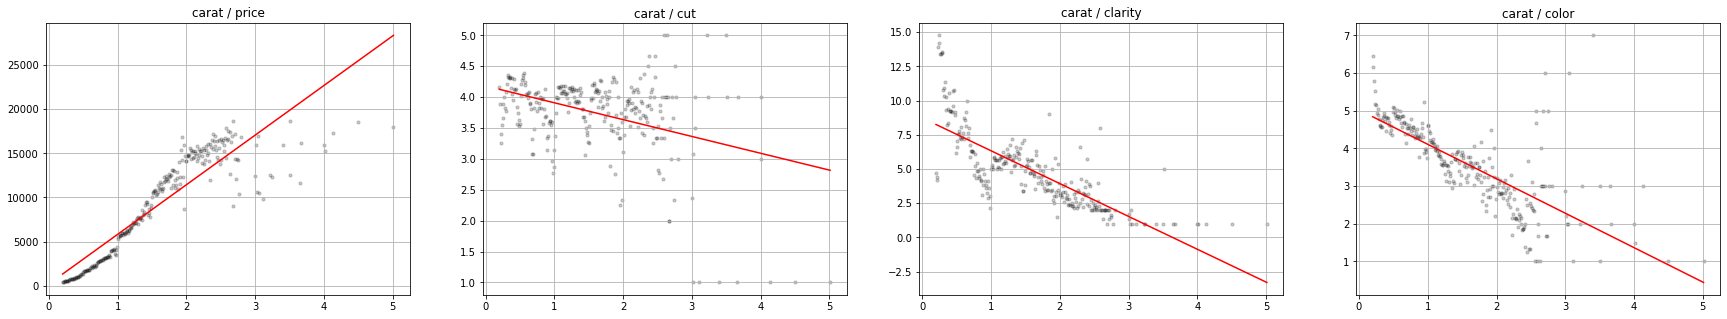

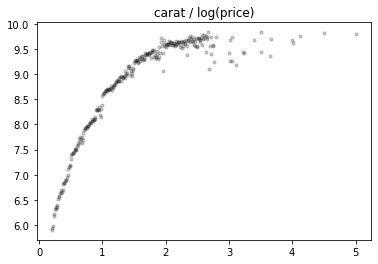

In [4]:
fig, axs = plt.subplots(1,4)
fig.set_size_inches(30, 5)

variables = [price, cut, clarity, color]
names = ['price', 'cut', 'clarity', 'color']

for idx, variable in enumerate(variables):
    axs[idx].scatter(carat, variable, color='black', alpha=0.2, s=10)
    z = np.polyfit(carat, variable, 1)
    p = np.poly1d(z)
    trend_h = p(carat)
    axs[idx].plot(carat,trend_h, "r-")
    axs[idx].grid()
    axs[idx].set_title(f'carat / {names[idx]}')
plt.show()

plt.scatter(carat, price_log, color='black', alpha=0.2, s=10)
plt.title("carat / log(price)")
plt.show()

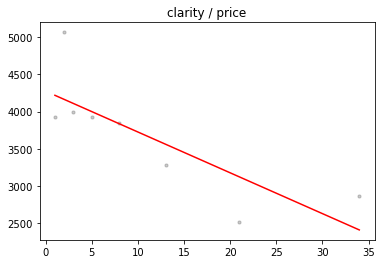

 
-54.7 x + 4272


In [5]:
clarityAmountDict = dict()
clarityPriceDict = dict()

for index, row in df.iterrows():
    if row['clarity'] not in clarityAmountDict.keys():
        clarityAmountDict[row['clarity']] = 0
    if row['clarity'] not in clarityPriceDict.keys():
        clarityPriceDict[row['clarity']] = 0

    clarityAmountDict[row['clarity']] += 1
    clarityPriceDict[row['clarity']] += row['price']


clarityPriceDict = {k: v/clarityAmountDict[k] for k, v in clarityPriceDict.items()}
clarityPriceDict = dict(sorted(clarityPriceDict.items()))

clarity = list(clarityPriceDict.keys())
price = list(clarityPriceDict.values())

clarityPrices = {"clarity": clarity, "price": price}
dfclarityPrices = pd.DataFrame(clarityPrices)
dfclarityPrices.to_csv(r'output/clarityPrices.csv', index=False)




plt.scatter(clarity, price, color='black', alpha=0.2, s=10)
z = np.polyfit(clarity, price, 1)
p = np.poly1d(z)
trend_h = p(clarity)
plt.plot(clarity,trend_h, "r-")
plt.title("clarity / price")
plt.show()

print(p)

---
# Data Analysis
[***Return to table of contents***](#table-of-contents)

For analysis we have created 3 bayesian models.

* Model 1 - uses 1st degree polynomial (a linear function)
* Model 2 - 

Expanding the first model by increasing the order of the polynomial allows for a better fit of the model to the observations, in terms of the data, and for value prediction. The third model is the departure from polynomial regression to the simulating from a Gaussian Process conditional on non-Gaussian observations.

The equations, parameters and differences of individual models are presented in the corresponding chapters.

---
## Loading dataset
[***Return to table of contents***](#table-of-contents)

---

In [6]:
df = pd.read_csv("output/averageValues.csv")
df.head()

print(df.describe())

            carat         price   price_log         cut     clarity  \
count  273.000000    273.000000  273.000000  273.000000  273.000000   
mean     1.608791   9242.669570    8.788366    3.742658    4.878807   
std      0.894875   5606.869496    1.005639    0.637292    2.748695   
min      0.200000    365.166667    5.900354    1.000000    1.000000   
25%      0.880000   3342.322581    8.114421    3.562500    2.866667   
50%      1.560000  10424.000000    9.251866    3.908046    4.558233   
75%      2.240000  14481.333333    9.580616    4.090909    6.031250   
max      5.010000  18701.000000    9.836332    5.000000   14.775591   

            color  
count  273.000000  
mean     3.552665  
std      1.107313  
min      1.000000  
25%      2.847458  
50%      3.602151  
75%      4.469989  
max      7.000000  


---
## Model 1 - Linear regression - 1st degree
[***Return to table of contents***](#table-of-contents)

Our first model was based on 1st degree polynomial function.

Model has form:

$$ y \sim \mathrm{Normal}(\alpha+X\beta,\sigma) $$

With parameter distributions set as follows:
$$ \alpha \sim \mathrm{Normal}(193, 5) $$
$$ \beta \sim \mathrm{Normal}(5625, 5) $$
$$ \sigma \sim \mathrm{Exponential}(5) $$

The required input data is the set of carats for which the user wants to make a prediction.

---
### Model 1 - Prior predictive check
[***Return to table of contents***](#table-of-contents)

First step is prior predicive check whether parameter values and distributions "make sense".

Parameters simulated from priors are a result of the model definition. The first order polynomial requires two parameters to equate the line, and the third is the width of the fit.

On the basis of the obtained parameter values, it can be concluded that the prior selection was successful, the values ​​are in line with the expectations.

On the basis of the obtained straight line fit to the measurements, it can be concluded that the prior predictive was successful. The obtained lines pass through the points as expected.

Priors were selected on the basis of the polynomial equation in the chapter [Plotting dataset and polynomial fitting](#plotting-dataset-and-polynomial-fitting).

![](./images/model_1_ppc.png)

---

In [7]:
model_1_ppc = CmdStanModel(stan_file='stanfiles/model_1_ppc.stan')

INFO:cmdstanpy:compiling stan file E:\Programowanie\Microsoft VS Code Projects\Data Analytics\DA_DiamondModel\stanfiles\model_1_ppc.stan to exe file E:\Programowanie\Microsoft VS Code Projects\Data Analytics\DA_DiamondModel\stanfiles\model_1_ppc.exe
INFO:cmdstanpy:compiled model executable: E:\Programowanie\Microsoft VS Code Projects\Data Analytics\DA_DiamondModel\stanfiles\model_1_ppc.exe
--- Translating Stan model to C++ code ---
bin/stanc.exe  --o=C:/Users/Marcin/AppData/Local/Temp/tmps5x4hlbj/tmp8yhf4r1f.hpp C:/Users/Marcin/AppData/Local/Temp/tmps5x4hlbj/tmp8yhf4r1f.stan
Warning in 'C:/Users/Marcin/AppData/Local/Temp/tmps5x4hlbj/tmp8yhf4r1f.stan', line 3, column 2: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
Warning in 'C:/Users/Marcin/AppData/Local/Temp/tmps5x4hlbj/tmp8yhf4r1f.stan

In [8]:
data_sim={'N':len(df), 'carat':df.carat}
model_1_sim = model_1_ppc.sample(data=data_sim, iter_sampling=1000, iter_warmup=0, chains=1, refresh=1000, fixed_param=True, seed=12345678)

INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


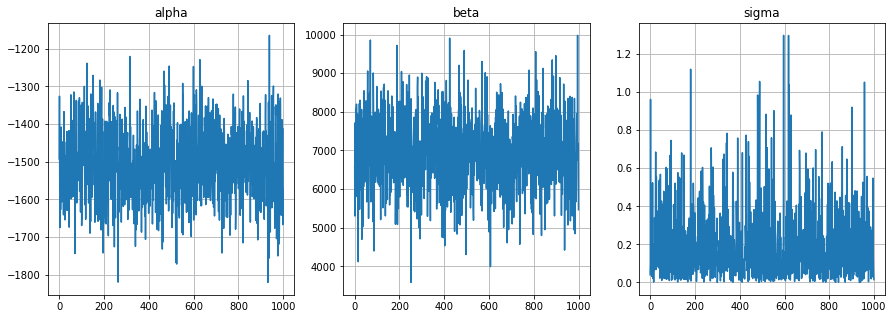

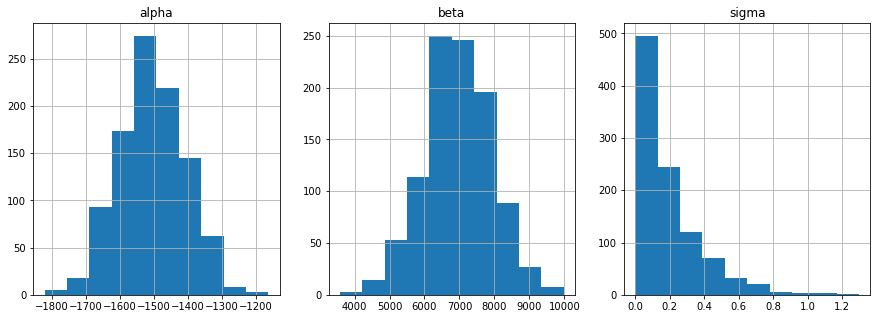

,mean,sd,hdi_3%,hdi_97%
alpha,-1506.23,96.89,-1669.54,-1320.31
beta,6963.81,967.87,5011.01,8633.69
sigma,0.19,0.19,0.00,0.54


In [9]:
alpha_sim = model_1_sim.stan_variable('alpha')
beta_sim = model_1_sim.stan_variable('beta')
sigma_sim = model_1_sim.stan_variable('sigma')
price_sim = model_1_sim.stan_variable('price')

fig, axs = plt.subplots(1,3)
fig.set_size_inches(15, 5)
axs[0].plot(alpha_sim)
axs[0].grid()
axs[0].set_title('alpha')
axs[1].plot(beta_sim)
axs[1].grid()
axs[1].set_title('beta')
axs[2].plot(sigma_sim)
axs[2].grid()
axs[2].set_title('sigma')
plt.show()

fig, axs = plt.subplots(1,3)
fig.set_size_inches(15, 5)
axs[0].hist(alpha_sim)
axs[0].grid()
axs[0].set_title('alpha')
axs[1].hist(beta_sim)
axs[1].grid()
axs[1].set_title('beta')
axs[2].hist(sigma_sim)
axs[2].grid()
axs[2].set_title('sigma')
plt.show()

az.summary(model_1_sim, var_names=['alpha','beta','sigma'], round_to=2, kind='stats')

On the basis of the obtained parameter values, it can be concluded that the prior selection was successful, the values ​​are in line with the expectations.

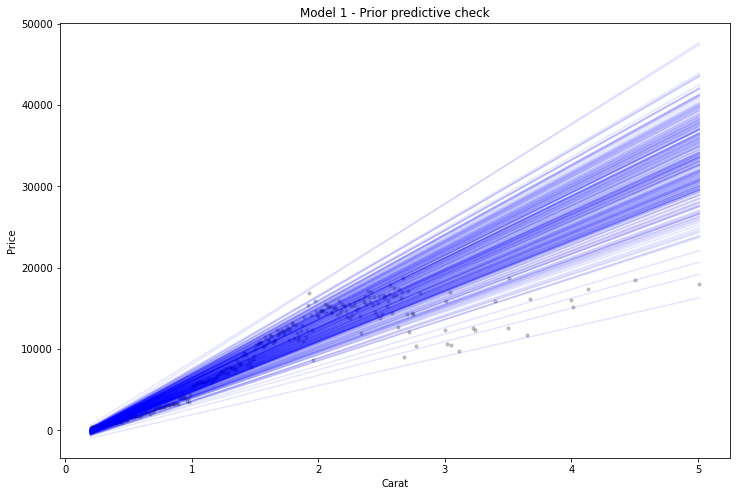

In [10]:
plt.figure(figsize=[12, 8])
for i in range(len(df)):
    plt.plot(df.carat, alpha_sim[i] + beta_sim[i] * df.carat, alpha=0.1, color='blue')
plt.scatter(df.carat, df.price, color='black', alpha=0.2, s=10)
plt.xlabel("Carat")
plt.ylabel("Price")
plt.title("Model 1 - Prior predictive check")
plt.show()

In [11]:
def pltQuants(x, y):
    qlvls = [0, 0.05, 0.25, 0.5, 0.75, 0.95, 1]
    quansList = [[], [], [], [], [], [], []]
    for i in range(y.shape[-1]):
        temp = y[:, i]
        for q, lvl in zip(quansList, qlvls):
            q.append(np.quantile(temp, lvl))
    for quantile in quansList:
        plt.plot(x, quantile)
    plt.legend(['min', '5%', '25%', '50%', '75%', '95%', 'max'])

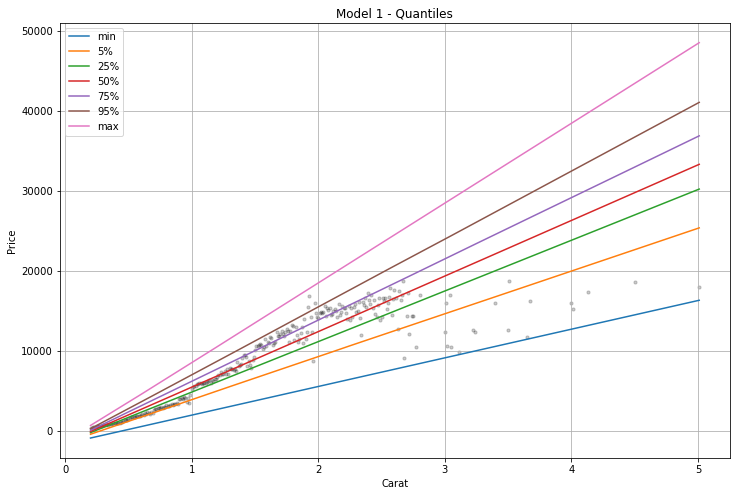

In [12]:
plt.figure(figsize=[12, 8])
pltQuants(df.carat, price_sim)
plt.scatter(df.carat, df.price, color='black', alpha=0.2, s=10)
plt.xlabel("Carat")
plt.ylabel("Price")
plt.title("Model 1 - Quantiles")
plt.grid()
plt.show()

On the basis of the obtained straight line fit to the measurements, it can be concluded that the prior predictive was successful. The obtained lines pass through the points as expected.

---
### Model 1 - Posterior analysis
[***Return to table of contents***](#table-of-contents)

After confirming that the priors values and trajectories are correct we can start a proper analysis.

No issues were detected during sampling.

A full model for 1st degree polynomial regression was created:

![](./images/model_lr.png)

---

In [13]:
model_1 = CmdStanModel(stan_file='stanfiles/model_1.stan')

INFO:cmdstanpy:found newer exe file, not recompiling


In [14]:
result_1 = model_1.sample(data=dict(N=len(df), carat=df.carat, price=df.price))
#print(result_lr.draws_pd())

INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.



---

### Model 1 - Stan linear regression
[***Return to table of contents***](#table-of-contents)

After creating, compiling and sampling the model we can observe the results. First of them is resulatant linear regression. The coefficients are read from results and function values are calculated for the plot.

---

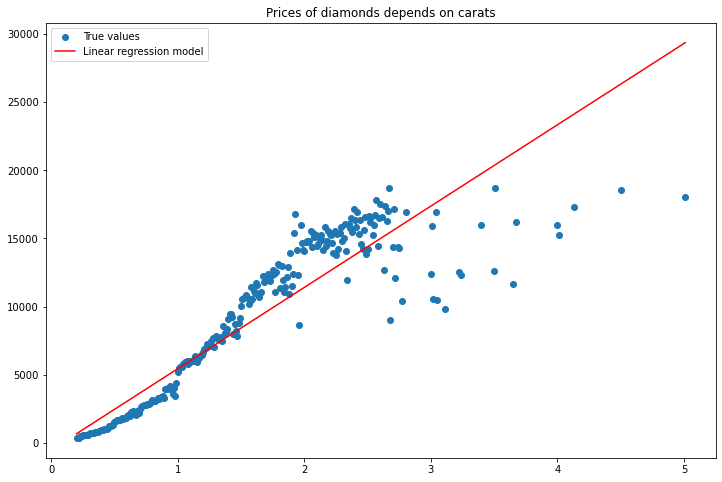

In [15]:
df_alpha = pd.DataFrame(result_1.stan_variables()["alpha"])
df_beta = pd.DataFrame(result_1.stan_variables()["beta"])
df_sigma = pd.DataFrame(result_1.stan_variables()["sigma"])

alpha = df_alpha.mean().to_numpy()
beta = df_beta.mean().to_numpy()
sigma= df_sigma.mean().to_numpy()

x = df.carat.values
y = alpha + beta*x

plt.figure(figsize=[12, 8])
plt.scatter(df.carat.values, df.price.values)
plt.plot(x, y, "-r")
plt.title("Prices of diamonds depends on carats")
plt.legend(["True values", "Linear regression model"])
plt.show()

---

### Model 1 - model parameters
[***Return to table of contents***](#table-of-contents)

We can also extract stan variables that are used in the final price prediction equation.

Based on the presented graphs and histograms of parameters, it can be concluded that parameter values ​​are relatively concentrated. 

Their slight dispersion is good due to the fact that it is not possible to perfectly match the lines to observations.

---

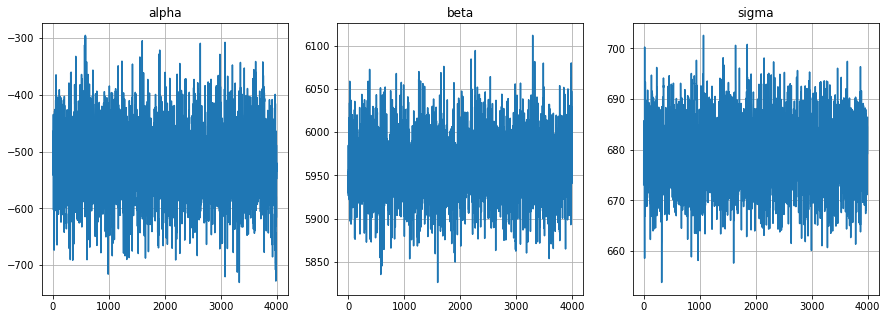

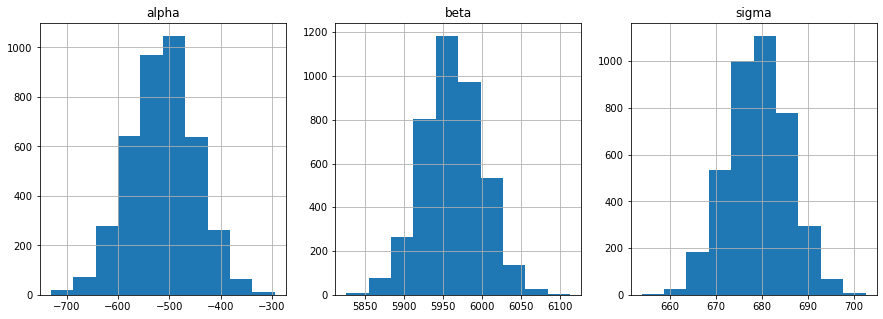

,mean,sd,hdi_3%,hdi_97%
alpha,-513.16,64.64,-631.42,-393.21
beta,5961.62,37.57,5888.99,6029.90
sigma,679.19,6.59,666.88,691.37


In [16]:
fig, axs = plt.subplots(1,3)
fig.set_size_inches(15, 5)
axs[0].plot(df_alpha)
axs[0].grid()
axs[0].set_title('alpha')
axs[1].plot(df_beta)
axs[1].grid()
axs[1].set_title('beta')
axs[2].plot(df_sigma)
axs[2].grid()
axs[2].set_title('sigma')
plt.show()

fig, axs = plt.subplots(1,3)
fig.set_size_inches(15, 5)
axs[0].hist(df_alpha)
axs[0].grid()
axs[0].set_title('alpha')
axs[1].hist(df_beta)
axs[1].grid()
axs[1].set_title('beta')
axs[2].hist(df_sigma)
axs[2].grid()
axs[2].set_title('sigma')
plt.show()

az.summary(result_1, var_names=['alpha','beta','sigma'], round_to=2, kind='stats')

---

### Model 1 - evaluation

[***Return to table of contents***](#table-of-contents)

We can now observe the results.

---

#### Model 1 - quantiles
[***Return to table of contents***](#table-of-contents)

After simulating we can analyze predictions. The quantiles follow a linear function. The right side of the plot gets squished as there are fewer diamonds of higher weights.

---

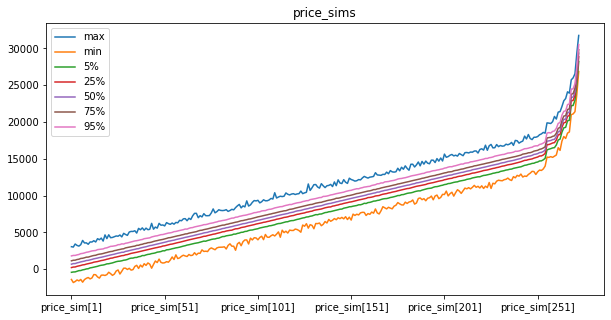

In [17]:
data = result_1.draws_pd()
price_sims = data[data.columns[283:556]]
#print(price_sims)

quans = pd.DataFrame({'max': price_sims.max(), 'min': price_sims.min(), '5%': price_sims.quantile(0.05), '25%': price_sims.quantile(0.25), '50%': price_sims.quantile(0.5), '75%': price_sims.quantile(0.75), '95%': price_sims.quantile(0.95)})
quans.plot(figsize=(10,5))
plt.title("price_sims")
plt.show()

---
#### Model 1 - predictions and density plot
[***Return to table of contents***](#table-of-contents)

As we can see the model is not sufficient to describe the phenomenon. 

While it's somewhat true for a narrow band of weights (about 1-1.5 carats), it is not accurate for low and med-high gems. It also gets progressively worse as true diamond prices plateau above 3 carat mark, most likely due to higher chances of defects.

The model predicted that most diamonds oscillate around value of 10 000 while the ground truth is exacly opposite, there are more low and high costs diamonds rather than the mid ones.

---

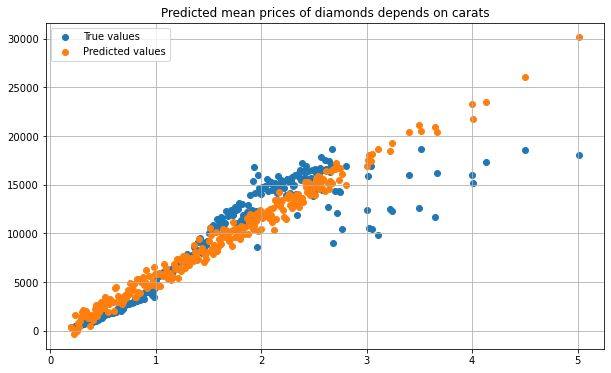

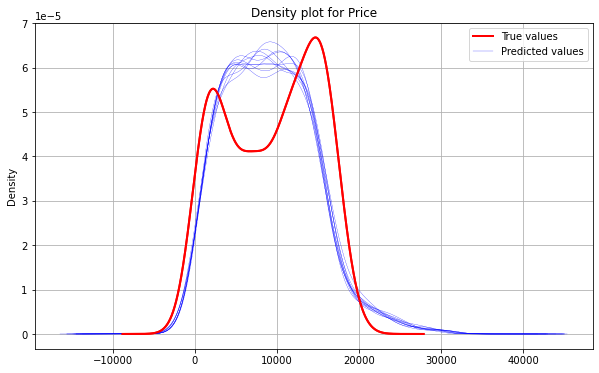

In [18]:
price_sim = result_1.stan_variable('price_sim')
plt.figure(figsize=[10,6])
plt.scatter(df.carat.values, df.price.values)
plt.scatter(df.carat.values, price_sim[1])
plt.title("Predicted mean prices of diamonds depends on carats")
plt.legend(["True values", "Predicted values"])
plt.grid()
plt.show()


df.price.plot.density(figsize=(10,6), linewidth=2, color='red')
for i in range(0,10):
    price_sims.iloc[i].plot.density(linewidth=0.25, color='blue')
df.price.plot.density(figsize=(10,6), linewidth=2, color='red')
plt.title('Density plot for Price')
plt.legend(["True values", "Predicted values"])
plt.grid()
plt.show()

---
## Model 2 - XXXLinear regression - 1st degree
[***Return to table of contents***](#table-of-contents)

Our first model was based on 1st degree polynomial function.

Model has form:

$$ y \sim \mathrm{Normal}(\alpha+X\beta,\sigma) $$

With parameter distributions set as follows:
$$ \alpha \sim \mathrm{Normal}(193, 5) $$
$$ \beta \sim \mathrm{Normal}(5625, 5) $$
$$ \sigma \sim \mathrm{Exponential}(5) $$

The required input data is the set of carats for which the user wants to make a prediction.

---
### Model 2 - Prior predictive check
[***Return to table of contents***](#table-of-contents)

First step is prior predicive check whether parameter values and distributions "make sense".

Parameters simulated from priors are a result of the model definition. The first order polynomial requires two parameters to equate the line, and the third is the width of the fit.

On the basis of the obtained parameter values, it can be concluded that the prior selection was successful, the values ​​are in line with the expectations.

On the basis of the obtained straight line fit to the measurements, it can be concluded that the prior predictive was successful. The obtained lines pass through the points as expected.

Priors were selected on the basis of the polynomial equation in the chapter [Plotting dataset and polynomial fitting](#plotting-dataset-and-polynomial-fitting).

![](./images/model_1_ppc.png)

---

In [33]:
model_2_ppc = CmdStanModel(stan_file='stanfiles/model_2_ppc.stan')

INFO:cmdstanpy:compiling stan file E:\Programowanie\Microsoft VS Code Projects\Data Analytics\DA_DiamondModel\stanfiles\model_2_ppc.stan to exe file E:\Programowanie\Microsoft VS Code Projects\Data Analytics\DA_DiamondModel\stanfiles\model_2_ppc.exe
ERROR:cmdstanpy:Stan program failed to compile:
--- Translating Stan model to C++ code ---
bin/stanc.exe  --o=C:/Users/Marcin/AppData/Local/Temp/tmp3uqea9xr/tmpwxeljkpi.hpp C:/Users/Marcin/AppData/Local/Temp/tmp3uqea9xr/tmpwxeljkpi.stan
Warning in 'C:/Users/Marcin/AppData/Local/Temp/tmp3uqea9xr/tmpwxeljkpi.stan', line 16, column 4: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
Semantic error in 'C:/Users/Marcin/AppData/Local/Temp/tmp3uqea9xr/tmpwxeljkpi.stan', line 18, column 8 to column 55:
   -------------------------------------------------

ValueError: Unable to compile Stan model file: E:\Programowanie\Microsoft VS Code Projects\Data Analytics\DA_DiamondModel\stanfiles\model_2_ppc.stan.

In [28]:
df2 = df[['carat', 'clarity']].copy()

In [30]:
data_sim={'n':len(df), 'k':2, 'X':df2, 'Y':df.price}
#model_2_sim = model_2_ppc.sample(data=data_sim, iter_sampling=1000, iter_warmup=0, chains=1, refresh=1000, fixed_param=True, seed=12345678)
model_2_sim = model_2_ppc.sample(data=data_sim)

INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


In [31]:
data = model_2_sim.draws_pd()
print(data)

         lp__  accept_stat__  stepsize__  treedepth__  n_leapfrog__  \
0    -2261.55       0.926994    0.134979          4.0          15.0   
1    -2265.01       0.999203    0.134979          5.0          31.0   
2    -2264.98       0.859223    0.134979          3.0          15.0   
3    -2265.25       0.892988    0.134979          4.0          15.0   
4    -2265.42       0.947411    0.134979          3.0           7.0   
...       ...            ...         ...          ...           ...   
3995 -2260.76       0.916290    0.151930          3.0          15.0   
3996 -2260.63       0.931072    0.151930          4.0          19.0   
3997 -2260.54       0.919424    0.151930          3.0          15.0   
3998 -2261.05       0.886045    0.151930          4.0          19.0   
3999 -2261.52       0.951021    0.151930          4.0          15.0   

      divergent__  energy__     alpha  beta[1]    beta[2]    sigma  
0             0.0   2263.47  1256.050  5501.54 -164.28400  2413.87  
1        

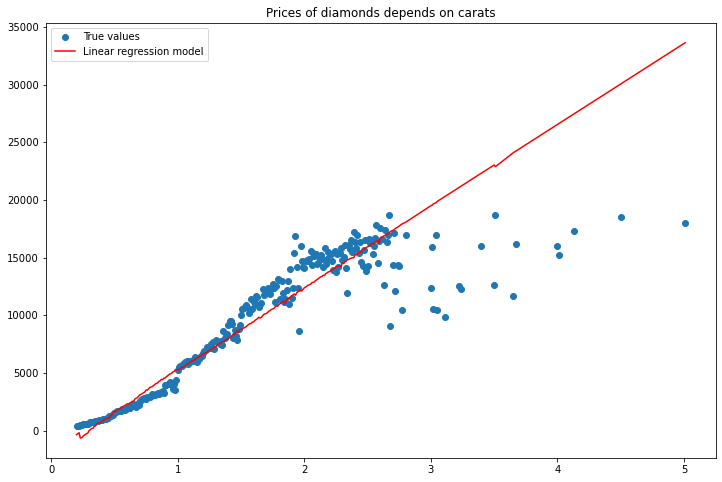

In [22]:
alpha_sim = model_2_sim.stan_variable('alpha')
beta_1_sim = model_2_sim.stan_variable('beta_1')
beta_2_sim = model_2_sim.stan_variable('beta_2')
sigma_sim = model_2_sim.stan_variable('sigma')
price_sim = model_2_sim.stan_variable('price')

alpha_sim = alpha_sim.mean()
beta_1_sim = beta_1_sim.mean()
beta_2_sim = beta_2_sim.mean()

x = df.carat
y = alpha_sim + beta_1_sim*df.carat + beta_2_sim*df.clarity

plt.figure(figsize=[12, 8])
plt.scatter(df.carat, df.price)
plt.plot(x, y, "-r")
plt.title("Prices of diamonds depends on carats")
plt.legend(["True values", "Linear regression model"])
plt.show()

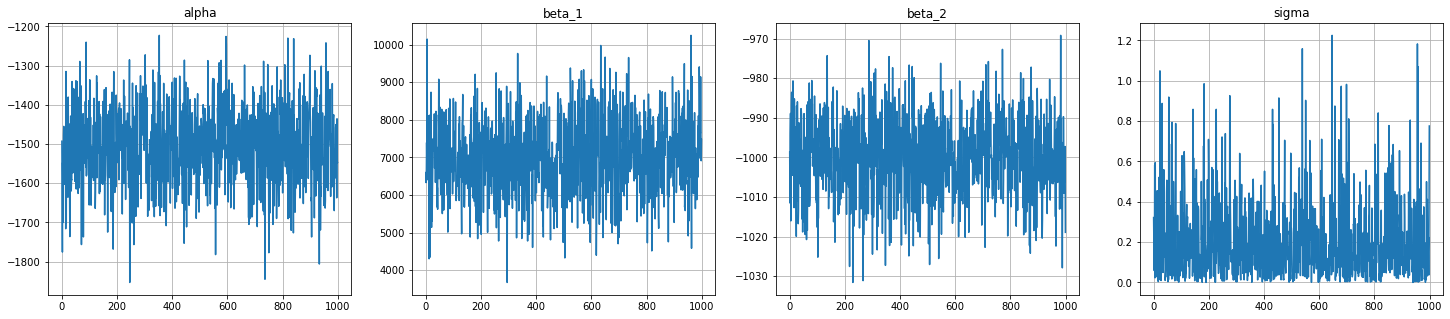

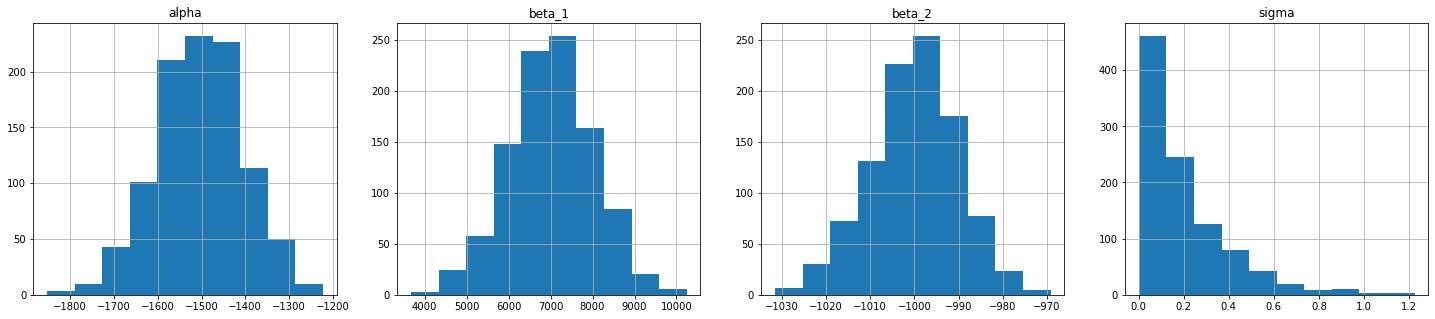

,mean,sd,hdi_3%,hdi_97%
alpha,-1503.78,100.09,-1690.49,-1326.86
beta_1,7023.28,1008.47,5122.26,8832.28
beta_2,-1000.03,9.94,-1020.00,-983.19
sigma,0.20,0.20,0.00,0.56


In [ ]:
alpha_sim = model_2_sim.stan_variable('alpha')
beta_1_sim = model_2_sim.stan_variable('beta_1')
beta_2_sim = model_2_sim.stan_variable('beta_2')
sigma_sim = model_2_sim.stan_variable('sigma')
price_sim = model_2_sim.stan_variable('price')

fig, axs = plt.subplots(1,4)
fig.set_size_inches(25, 5)
axs[0].plot(alpha_sim)
axs[0].grid()
axs[0].set_title('alpha')
axs[1].plot(beta_1_sim)
axs[1].grid()
axs[1].set_title('beta_1')
axs[2].plot(beta_2_sim)
axs[2].grid()
axs[2].set_title('beta_2')
axs[3].plot(sigma_sim)
axs[3].grid()
axs[3].set_title('sigma')
plt.show()

fig, axs = plt.subplots(1,4)
fig.set_size_inches(25, 5)
axs[0].hist(alpha_sim)
axs[0].grid()
axs[0].set_title('alpha')
axs[1].hist(beta_1_sim)
axs[1].grid()
axs[1].set_title('beta_1')
axs[2].hist(beta_2_sim)
axs[2].grid()
axs[2].set_title('beta_2')
axs[3].hist(sigma_sim)
axs[3].grid()
axs[3].set_title('sigma')
plt.show()

az.summary(model_2_sim, var_names=['alpha','beta_1','beta_2','sigma'], round_to=2, kind='stats')

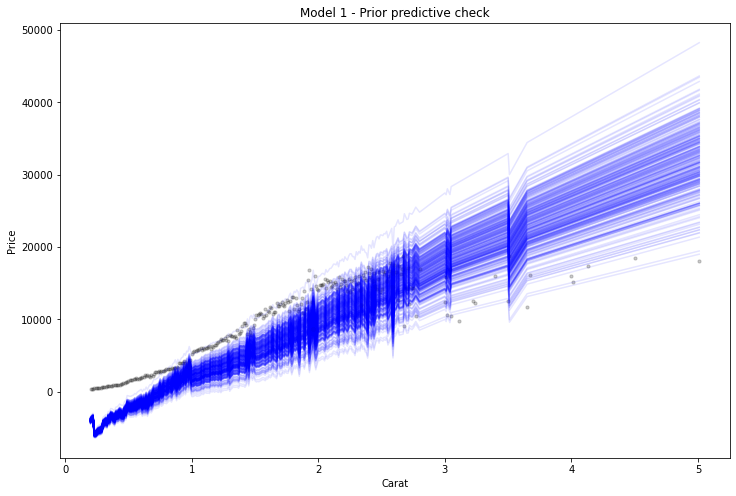

In [ ]:
plt.figure(figsize=[12, 8])
for i in range(len(df)):
    plt.plot(df.carat, alpha_sim[i] + beta_1_sim[i] * df.carat + beta_2_sim[i] * df.clarity, alpha=0.1, color='blue')
plt.scatter(df.carat, df.price, color='black', alpha=0.2, s=10)
plt.xlabel("Carat")
plt.ylabel("Price")
plt.title("Model 1 - Prior predictive check")
plt.show()

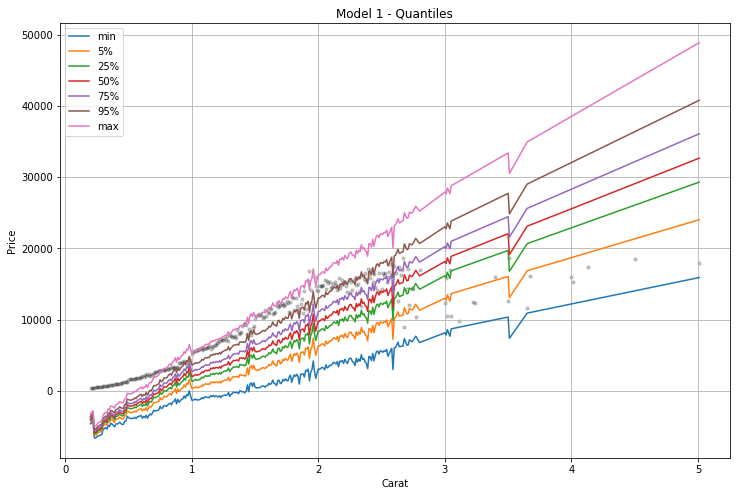

In [ ]:
plt.figure(figsize=[12, 8])
pltQuants(df.carat, price_sim)
plt.scatter(df.carat, df.price, color='black', alpha=0.2, s=10)
plt.xlabel("Carat")
plt.ylabel("Price")
plt.title("Model 1 - Quantiles")
plt.grid()
plt.show()

---

## Model Comparison
[***Return to table of contents***](#table-of-contents)

Leave-one-out cross-validation (LOO) and the widely applicable information criterion (WAIC) are methods for estimating pointwise out-of-sample prediction accuracy from a fitted Bayesian model using the log-likelihood evaluated at the posterior simulations of the parameter values. 
The comparison function used allows the models to be assessed against each of these criteria, ordering them from best to worst.

---

### PSIS-LOO Criterion
[***Return to table of contents***](#table-of-contents)

Based on the comparison of the models using the PSIS-LOO criterion, it can be concluded that:
* 4th degree polynomial regression has the lowest rank (which means the best model of all)
* 4th degree polynomial regression has the highest out-of-sample predictive fit ('loo' column), while the gaussian process has the lowest,
* 4th degree polynomial regression has the highest probability of the correctness of the model ('weight' column), while the gaussian process has the lowest,
* standard error of the difference information criteria between each model and the top ranked model ('dse' column) show that the Gaussian process model deviates from the polynomial much more than linear,
* for all models there is a warning that indicates that the computation of the information criteria may not be reliable.

---



                       rank           loo        p_loo         d_loo  \
polynomial_regression     0  -3205.103211    91.695171      0.000000   
linear_regression         1  -3864.659531    25.190933    659.556320   
gaussian_process          2 -21682.021253  1020.422193  18476.918042   

                         weight           se          dse  warning loo_scale  
polynomial_regression  0.692435   223.274999     0.000000     True       log  
linear_regression      0.132938   225.577669   187.687729     True       log  
gaussian_process       0.174627  3366.675754  3161.975843     True       log  


<AxesSubplot:xlabel='Log'>

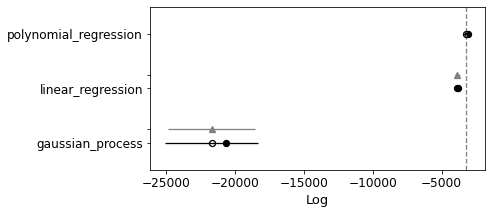

In [ ]:
data = dict(linear_regression = result_lr, polynomial_regression = result_pr, gaussian_process = result_gp)
comp_loo = az.compare(data, ic = "loo")
print('\n')
print(comp_loo)
az.plot_compare(comp_loo)

---

### WAIC Criterion
[***Return to table of contents***](#table-of-contents)

Based on the comparison of the models using the WAIC criterion, it can be concluded that the conclusions are identical to the previous criterion, i.e.:
* 4th degree polynomial regression has the lowest rank (which means the best model of all)
* 4th degree polynomial regression has the highest out-of-sample predictive fit ('waic' column), while the gaussian process has the lowest,
* 4th degree polynomial regression has the highest probability of the correctness of the model ('weight' column), while the gaussian process has the lowest,
* standard error of the difference information criteria between each model and the top ranked model ('dse' column) show that the Gaussian process model deviates from the polynomial much more than linear,
* for all models there is a warning that indicates that the computation of the information criteria may not be reliable.

---



                       rank          waic       p_waic        d_waic  \
polynomial_regression     0  -3211.742095    98.334055      0.000000   
linear_regression         1  -3864.725457    25.256859    652.983362   
gaussian_process          2 -22547.212019  1885.612960  19335.469924   

                         weight           se          dse  warning waic_scale  
polynomial_regression  0.692625   224.928587     0.000000     True        log  
linear_regression      0.132798   225.610731   185.899939     True        log  
gaussian_process       0.174577  3579.084304  3372.956224     True        log  


<AxesSubplot:xlabel='Log'>

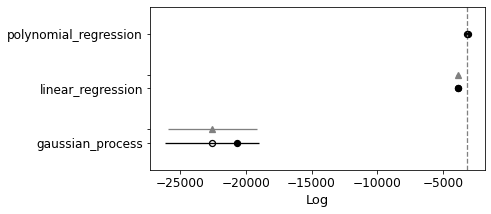

In [ ]:
comp_waic = az.compare(data, ic = "waic")
print('\n')
print(comp_waic)
az.plot_compare(comp_waic)

---

# Model Comparison - conclusions
[***Return to table of contents***](#table-of-contents)

Comparing the models, can agree with the results that the polynomial regression model produces the best results. If we are talking about the worst model, on the basis of the obtained price value prediction charts it can be concluded that the Gaussian process coped better with the fitting than the linear regression. This opinion differs from the result of the information criterion. As mentioned earlier, polynomial regression gave a satisfactory result for the given range. For higher carat values, the results could be different, but due to the fact that they are very rare, they were not taken into account in the final evaluation of the correctness of the model.

---